# PyTorch: Transfer Learning 

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of suffcient size. Instead it is common ro pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 millin images with 1000 categories), and then use the ConvNet either as an initialization of a fixed feature extractor for the tak of the interest. 

The two major transfer learning scenarios look as follows:
* Finetununing the convnet: Instead of random initialization, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training ooks as ususal. 
* ConvNet as fixed feature extractor: Here, we will freeze the weights for all of the network that of the final fully connected layer. This last fully connected layer is repaced with a new one with random weights and only this layer is trained. 


In [1]:
%matplotlib inline
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
import copy

plt.ion() #interactive mode

# Load Data
 We will use torchvision and torch.utilsdata packages for loading the data. 
 
 The problem we're going to solve today is to train a model to classify ants and bees. We have about 120 training images each for andt and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonable well. 
 
 This dataset is a very small subset of imagenet. 

In [2]:
#Data augmentation and normalization for training 
# Normalization and validation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = os.path.abspath('./hymenoptera_data/')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualize a few images

Let's visualize a few images in order to understand the data augmentations


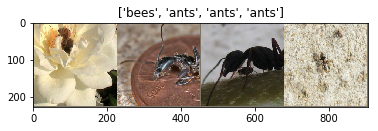

In [3]:
%matplotlib inline

def imshow(inp, title=None):
    """ imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, .406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean 
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) #pause a bit so update the plots
    
#get a batch for training data 
inputs, classes = next(iter(dataloaders['train']))

#make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model 

Now let's write  a general function to train a model. Here we eill illustrate:

* Scheduling the learning rate
* Saving the best model 

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualizing the model predictions

Generic function to display predictions for a few images 

In [16]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer

In [6]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_fit = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

#Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

#Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train and evaluate


In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5107 Acc: 0.7500
val Loss: 0.3099 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.6267 Acc: 0.7295
val Loss: 0.2757 Acc: 0.9020

Epoch 2/24
----------
train Loss: 0.4273 Acc: 0.8279
val Loss: 0.7882 Acc: 0.7647

Epoch 3/24
----------
train Loss: 0.6011 Acc: 0.7623
val Loss: 0.4370 Acc: 0.9020

Epoch 4/24
----------
train Loss: 0.6974 Acc: 0.7992
val Loss: 0.3788 Acc: 0.8431

Epoch 5/24
----------
train Loss: 0.6201 Acc: 0.7705
val Loss: 0.2864 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.6011 Acc: 0.7705
val Loss: 0.2436 Acc: 0.9216

Epoch 7/24
----------
train Loss: 0.4288 Acc: 0.8361
val Loss: 0.2171 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.4267 Acc: 0.8197
val Loss: 0.2051 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.3829 Acc: 0.8484
val Loss: 0.2019 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.2770 Acc: 0.9016
val Loss: 0.2151 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.3375 Acc: 0.8648
val Loss: 0.2157 Acc: 0.9281

Ep

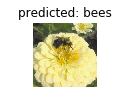

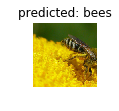

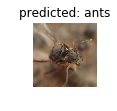

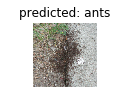

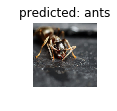

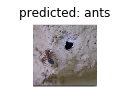

In [17]:
visualize_model(model_ft)